# Transformers project, classification

In [1]:
import io
import pathlib
import random
import numpy as np
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.patches
import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
import torch.nn as nn
import zipfile

from chronos import ChronosPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch import Tensor as T
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score
from tqdm.notebook import tqdm

In [2]:
T_MAX = 512
BATCH_SIZE = 256

## Data

### Load Data

In [3]:
with zipfile.ZipFile('data/price_data.zip', 'r') as data_zip:
    csv_files = []
    csv_file_names = [name for name in data_zip.namelist() if name.endswith('.csv')]

    for csv_file_name in csv_file_names:
        csv_file_stem = pathlib.Path(csv_file_name).stem
        with data_zip.open(csv_file_name) as csv_file:
            csv_df = pd.read_csv(csv_file, index_col=0)
            csv_df = csv_df.drop(columns=['Unnamed: 0'])
            csv_df['datetime'] = pd.to_datetime(csv_df['datetime'])
            csv_df = csv_df.set_index('datetime').sort_index().reindex() # In case there are missing days (there are not)
            csv_df = csv_df.reset_index()
            csv_df['currency'] = csv_file_stem
            csv_files.append(csv_df)

cur_df = pd.concat(csv_files).reset_index(names=['t'])

In [4]:
cur_df

,t,datetime,low_x,high_x,open_x,close_x,volumefrom_x,volumeto_x,label,currency
0,0,2018-03-02,1.22600,1.29000,1.24000,1.23200,13683.69,17064.23,0.0,ABT
1,1,2018-03-03,1.21700,1.36700,1.23200,1.21700,177141.97,221675.04,0.0,ABT
2,2,2018-03-04,1.12800,1.26700,1.21700,1.18600,174835.25,204107.30,0.0,ABT
3,3,2018-03-05,1.16100,1.25000,1.18600,1.18300,68595.33,82557.18,0.0,ABT
4,4,2018-03-06,1.01000,1.22400,1.18300,1.02300,341941.25,377663.88,0.0,ABT
...,...,...,...,...,...,...,...,...,...,...
311141,239,2021-04-03,0.04330,0.05622,0.04533,0.05574,9656321.69,474194.03,0.0,XTZDOWN
311142,240,2021-04-04,0.04712,0.05736,0.05574,0.04894,3948512.75,202690.50,0.0,XTZDOWN
311143,241,2021-04-05,0.02530,0.05176,0.04894,0.03018,55776776.20,1851324.23,0.0,XTZDOWN
311144,242,2021-04-06,0.02165,0.03309,0.03018,0.02900,99144511.87,2754986.28,0.0,XTZDOWN


In [5]:
print('Total "bubble" examples:', cur_df['label'].sum())
print('Share of "bubble" observations:', cur_df['label'].sum() / cur_df['label'].count())

Total "bubble" examples: 11997.0
Share of "bubble" observations: 0.03855746177035861


In [6]:
cur_df[['label', 'currency']].groupby(['currency']).count().sort_values('label')

,label
currency,
UNIDOWN,190
EGLD,190
ORN,190
UNIUP,190
USDG,191
...,...
ZEC,1621
RRT,1640
LTC,1688


In [7]:
eth_df = cur_df.loc[cur_df['currency'] == 'ETH',:].set_index(['t'])
eth_df

,datetime,low_x,high_x,open_x,close_x,volumefrom_x,volumeto_x,label,currency
t,,,,,,,,,
0,2016-03-09,10.10,11.20,10.30,11.20,41.17,4.484300e+02,0.0,ETH
1,2016-03-10,11.07,11.85,11.20,11.75,1.03,1.209000e+01,0.0,ETH
2,2016-03-11,11.75,11.95,11.75,11.95,50.85,6.074200e+02,0.0,ETH
3,2016-03-12,11.95,13.45,11.95,12.92,237.78,3.057520e+03,0.0,ETH
4,2016-03-13,12.92,15.07,12.92,15.07,369.64,5.243670e+03,0.0,ETH
...,...,...,...,...,...,...,...,...,...
1850,2021-04-03,2001.00,2137.60,2133.10,2007.60,75383.84,1.562022e+08,1.0,ETH
1851,2021-04-04,1979.60,2092.00,2007.60,2077.40,42193.76,8.607146e+07,1.0,ETH
1852,2021-04-05,1998.70,2131.60,2077.40,2107.40,66310.69,1.382024e+08,1.0,ETH


### Split data into train and test set

In [8]:
# Allocate about 10% of data for testing.
# In order to not leak data from test set to train set, split the data by currencies.
counts = cur_df[['currency', 'open_x']].groupby('currency').count().rename(columns={'open_x': 'count'})
counts['weight'] = counts['count'] / counts['count'].sum()
#sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None, ignore_index=False)[source]
test_currencies = counts.sample(frac=0.075, weights=counts['weight'], random_state=655976, axis=0).index.values
train_currencies = [x for x in counts.index.values if not x in test_currencies]

train_df = cur_df.loc[[cur in train_currencies for cur in cur_df['currency']],:]
test_df = cur_df.loc[[cur in test_currencies for cur in cur_df['currency']],:]
train_df.shape, test_df.shape

((279888, 10), (31258, 10))

In [9]:
def preprocess_ts(df, value_col):
    # Since I don't know how Chronos masks the inputs, I create a separate time series for each observation, to make sure Chronos does not use any future information.
    # For each observation in the time series, take the context of up to 512 previous observations.
    # As a result, we get a matrix with shape (n_obs, min(n_obs, 512)).
    ts_shape = (df.shape[0], min(df.shape[0], T_MAX))
    ts_matrix = np.full(ts_shape, np.nan)

    for i in range(ts_shape[0]):
        context_len = min(i+1, ts_shape[1])
        ts_matrix[i,-context_len:] = df[value_col].iloc[max(0, i-T_MAX+1):i+1]

    return ts_matrix

In [10]:
preprocess_ts(eth_df, 'open_x')

array([[    nan,     nan,     nan, ...,     nan,     nan,   10.3 ],
       [    nan,     nan,     nan, ...,     nan,   10.3 ,   11.2 ],
       [    nan,     nan,     nan, ...,   10.3 ,   11.2 ,   11.75],
       ...,
       [ 185.  ,  189.68,  185.1 , ..., 2133.1 , 2007.6 , 2077.4 ],
       [ 189.68,  185.1 ,  187.16, ..., 2007.6 , 2077.4 , 2107.4 ],
       [ 185.1 ,  187.16,  188.69, ..., 2077.4 , 2107.4 , 2112.1 ]])

## Baseline Classification Model

In [11]:
def preprocess_price_data_rf(df):
    torch.cuda.empty_cache()
    
    ts = np.full((df.shape[0], 512), np.nan)
    groups = np.full(df.shape[0], np.nan, dtype=object)
    labels = np.full(df.shape[0], np.nan)
    
    obs_offset = 0
    
    progress_bar = tqdm(df['currency'].unique())
    
    for currency in progress_bar:
        loc = df['currency'] == currency
        cur_df = df.loc[loc,:].set_index(['t'])
        n_obs = cur_df.shape[0]
    
        labels[obs_offset:obs_offset+n_obs] = df.loc[loc,'label']
        groups[obs_offset:obs_offset+n_obs] = currency
        ts[obs_offset:obs_offset+n_obs,-min(n_obs, 512):] = preprocess_ts(cur_df, 'open_x')
        obs_offset += n_obs

    return ts, labels, groups

In [12]:
rf_train_X, rf_train_y, rf_train_currencies = preprocess_price_data_rf(train_df)
rf_train_X.shape, rf_train_y.shape, np.unique(rf_train_currencies).shape

  0%|          | 0/422 [00:00<?, ?it/s]

((279888, 512), (279888,), (422,))

In [13]:
rf_test_X, rf_test_y, rf_test_currencies = preprocess_price_data_rf(test_df)
rf_test_X.shape, rf_test_y.shape, np.unique(rf_test_currencies).shape

  0%|          | 0/34 [00:00<?, ?it/s]

((31258, 512), (31258,), (34,))

In [14]:
train_idxs = np.random.choice(np.arange(rf_train_X.shape[0]), size=10000, replace=False)
s_rf_train_X, s_rf_train_y, s_rf_train_currencies = rf_train_X[train_idxs,:], rf_train_y[train_idxs], rf_train_currencies[train_idxs]
s_rf_train_X.shape, s_rf_train_y.shape, np.unique(s_rf_train_currencies).shape

((10000, 512), (10000,), (422,))

In [15]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
#from sktime.pipeline import make_pipeline
#from sktime.transformations.panel.catch22 import Catch22

#catch22 = Catch22()
#rf = RandomForestClassifier(n_estimators=500)
#rf_pipe = make_pipeline(catch22, rf)

#rf_pipe.fit(rf_train_X, rf_train_y)

#cross_val_score(rf_pipe, s_rf_train_X, y=s_rf_train_y, groups=s_rf_train_currencies, scoring='f1', cv=StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=334160))

## Embedding Based Classification Model

### Get Embeddings

In [16]:
# TODO We could try to make the time series stationary before passing it to Chronos.

In [17]:
pipeline = ChronosPipeline.from_pretrained(
    'amazon/chronos-t5-small',
    device_map='cuda',
    torch_dtype=torch.bfloat16,
)

In [18]:
def preprocess_price_data(df):
    torch.cuda.empty_cache()
    
    embeddings = np.full((df.shape[0], 512), np.nan)
    groups = np.full(df.shape[0], np.nan, dtype=object)
    labels = np.full(df.shape[0], np.nan)
    
    obs_offset = 0
    
    progress_bar = tqdm(df['currency'].unique())
    
    for currency in progress_bar:
        loc = df['currency'] == currency
        cur_df = df.loc[loc,:].set_index(['t'])
        n_obs = cur_df.shape[0]
    
        matrix = preprocess_ts(cur_df, 'open_x')
        cur_embeddings = np.full((n_obs, 512), np.nan)
    
        for i in range(n_obs // BATCH_SIZE + 1):
            batch_start, batch_end = i*BATCH_SIZE, min((i+1)*BATCH_SIZE, matrix.shape[0])
            progress_bar.set_postfix({
                'currency': currency,
                'n_obs': n_obs,
                'batch_start': batch_start,
                'batch_end': batch_end,
            })
    
            context = torch.tensor(matrix[batch_start:batch_end,:])
            # The encoder embeddings are shaped (batch_size, context_length, d_model)
            # or (batch_size, context_length + 1, d_model), where context_length
            # is the size of the context along the time axis if a 2D tensor was provided
            # or the length of the longest time series, if a list of 1D tensors was
            # provided, and the extra 1 is for EOS.
            embeddings_torch, _tokenizer_state = pipeline.embed(context)
            # EOS is the last token, our token of interest is the second to last
            cur_embeddings[batch_start:batch_end,:] = embeddings_torch.float().numpy()[:,-2,:]
    
        labels[obs_offset:obs_offset+n_obs] = df.loc[loc,'label']
        groups[obs_offset:obs_offset+n_obs] = currency
        embeddings[obs_offset:obs_offset+n_obs,:] = cur_embeddings
        obs_offset += n_obs

    return embeddings, labels, groups

def save_embeddings(embeddings, labels, groups, prefix):
    print(f'Saving embeddings to file prefix: "{prefix}"')
    with open(f'{prefix}-X.npy', 'wb') as f:
        np.save(f, embeddings)
    with open(f'{prefix}-y.npy', 'wb') as f:
        np.save(f, labels)
    with open(f'{prefix}-group.npy', 'wb') as f:
        np.save(f, groups)
    with open(f'{prefix}', 'a') as f:
        pass

def load_embeddings(prefix):
    print(f'Loading embeddings from file prefix: "{prefix}"')
    with open(f'{prefix}-X.npy', 'rb') as f:
        embeddings = np.load(f)
    with open(f'{prefix}-y.npy', 'rb') as f:
        labels = np.load(f)
    with open(f'{prefix}-group.npy', 'rb') as f:
        groups = np.load(f, allow_pickle=True)

    return embeddings, labels, groups

In [19]:
train_path = 'tmp/train'

if pathlib.Path(train_path).exists():
    train_X, train_y, train_currencies = load_embeddings(train_path)
else:
    train_X, train_y, train_currencies = preprocess_price_data(train_df)
    save_embeddings(train_X, train_y, train_currencies, train_path)

train_X.shape, train_y.shape, np.unique(train_currencies).shape

Loading embeddings from file prefix: "tmp/train"


((279888, 512), (279888,), (422,))

In [20]:
test_path = 'tmp/test'

if pathlib.Path(test_path).exists():
    test_X, test_y, test_currencies = load_embeddings(test_path)
else:
    test_X, test_y, test_currencies = preprocess_price_data(test_df)
    save_embeddings(test_X, test_y, test_currencies, test_path)

test_X.shape, test_y.shape, np.unique(test_currencies).shape

Loading embeddings from file prefix: "tmp/test"


((31258, 512), (31258,), (34,))

In [21]:
train_X, train_y = train_X.astype(np.float32), train_y.astype(np.float32)

In [22]:
test_X, test_y = test_X.astype(np.float32), test_y.astype(np.float32)

### Specify and train model

In [23]:
torch.cuda.empty_cache()

In [24]:
class SimpleDataset(Dataset):
    def __init__(self, values, labels, transform=None):
        assert values.shape[0] == labels.shape[0]
        self.values = values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.values.shape[0]

    def __getitem__(self, idx):
        value = self.values[idx,:]
        label = self.labels[idx]
        
        if self.transform:
            value = self.transform(value)

        return value, label

In [25]:
train_dataset = SimpleDataset(train_X, train_y)
test_dataset = SimpleDataset(test_X, test_y)

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [27]:
class FFN(nn.Sequential):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim):
        super().__init__(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim)
        )

class ClassificationModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()

        self.ffn = FFN(input_dim, hidden_dim, output_dim)

    def forward(self, x: T):
        out = self.ffn(x)
        return out

In [28]:
def train(loader, model, loss_obj, optimizer):
    total_loss = 0.
    model.train()

    for inputs, labels in loader:
        # Move data onto the device
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)

        # Forward and backward pass
        optimizer.zero_grad()
        pred = model(inputs)
        loss = loss_obj(pred, labels[:,None])
        loss.backward()
        optimizer.step()

        # Training loss
        total_loss += loss.item()

    return total_loss / len(loader)

def validate(loader, model, loss_obj, metric_obj):
    total_loss = 0.
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:
            # Move data onto the device
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # Forward pass
            pred = model(inputs)

            # Validation loss and validation metric
            total_loss += loss_obj(pred, labels[:,None]).item()
            metric_obj(pred, labels[:,None])

    return total_loss / len(loader), metric_obj.compute().item()

def reset_weights(m):
  """
    Try resetting model weights to avoid
    weight leakage.
  """
  for layer in m.children():
      if hasattr(layer, 'reset_parameters'):
          #print(f'Reset trainable parameters of layer = {layer}')
          layer.reset_parameters()

def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)

def load_model(model, load_path):
    model.load_state_dict(torch.load(load_path, weights_only=True))
    model.eval()

    return model

In [40]:
n_epochs = 40
batch_size = 100
k_folds = 5
opt_lr = 1e-4
hidden_state = 512

torch.manual_seed(674003)

kfold = StratifiedGroupKFold(n_splits=k_folds, shuffle=True, random_state=334160)

progress_bar = tqdm(enumerate(kfold.split(train_X, train_y, train_currencies)), total=k_folds)

train_losses = np.zeros((k_folds, n_epochs))
valid_losses = np.zeros((k_folds, n_epochs))
valid_metrics = np.zeros((k_folds, n_epochs))

for fold, (train_ids, valid_ids) in progress_bar:
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_subsampler)

    model = ClassificationModel(512, hidden_state, 1).to(device=device)
    model.apply(reset_weights)

    # The label classes are imbalanced, use class weights
    # TODO Alternatively, we could try over- or undersampling.
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_y), y=train_y)
    class_weights = torch.from_numpy(class_weights).to(device=device, dtype=torch.float32)

    loss_obj = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    metric_obj = BinaryF1Score().to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=opt_lr)

    for epoch in range(n_epochs):
        train_loss = train(train_loader, model, loss_obj, optimizer)
        valid_loss, valid_metric = validate(valid_loader, model, loss_obj, metric_obj)
        train_losses[fold, epoch] = train_loss
        valid_losses[fold, epoch] = valid_loss
        valid_metrics[fold, epoch] = valid_metric

        progress_bar.set_postfix({
            'fold': fold,
            'train_size': len(train_ids),
            'valid_size': len(valid_ids),
            'train_pos_share': train_y[train_ids].sum() / len(train_ids),
            'valid_pos_share': train_y[valid_ids].sum() / len(valid_ids),
            'batch_size': batch_size,
            'epoch': epoch,
            'train_loss': train_losses[fold, epoch],
            'valid_loss': valid_losses[fold, epoch],
            'valid_metric': valid_metrics[fold, epoch],
        })

    save_model(model, f'tmp/classification-h{hidden_state}-f{fold}.pt')

print('Average cross-validation train loss: ', train_losses[:,-1].mean())
print('Average cross-validation validation loss: ', valid_losses[:,-1].mean())
print('Average cross-validation validation metric: ', valid_metrics[:,-1].mean())

  0%|          | 0/5 [00:00<?, ?it/s]

Average cross-validation train loss:  0.1786708178133976
Average cross-validation validation loss:  0.20679093275336008
Average cross-validation validation metric:  0.6226263523101807


### Hyperparameter Optimization: Hidden State Size

Number of epochs: 20

#### 16

* Average cross-validation train loss:  0.20878535174736443
* Average cross-validation validation loss:  0.22358802694985508
* Average cross-validation validation metric:  0.5902624368667603

#### 32

* Average cross-validation train loss:  0.20231927513617004
* Average cross-validation validation loss:  0.21838721214787923
* Average cross-validation validation metric:  0.5972298860549927

#### 64

* Average cross-validation train loss:  0.1973199551420885
* Average cross-validation validation loss:  0.21469491287116454
* Average cross-validation validation metric:  0.603781795501709

#### 128

* Average cross-validation train loss:  0.1928872263502754
* Average cross-validation validation loss:  0.21294253832758034
* Average cross-validation validation metric:  0.6095029830932617

#### 256

* Average cross-validation train loss:  0.18954740078208177
* Average cross-validation validation loss:  0.21085917309027052
* Average cross-validation validation metric:  0.6131279706954956

#### 512

* Average cross-validation train loss:  0.18690849989057012
* Average cross-validation validation loss:  0.20982852209167788
* Average cross-validation validation metric:  0.6149063348770142

#### 1024

* Average cross-validation train loss:  0.18501625408449904
* Average cross-validation validation loss:  0.2131148347756963
* Average cross-validation validation metric:  0.6184088945388794

#### 2048

* Average cross-validation train loss:  0.18399335134137149
* Average cross-validation validation loss:  0.21059076735823629
* Average cross-validation validation metric:  0.6229145646095275

#### 4096

* Average cross-validation train loss:  0.1837845471809602
* Average cross-validation validation loss:  0.21353556632851606
* Average cross-validation validation metric:  0.6238965630531311

#### 8192

* Average cross-validation train loss:  0.1844976431665414
* Average cross-validation validation loss:  0.21216338046139555
* Average cross-validation validation metric:  0.6238183498382568

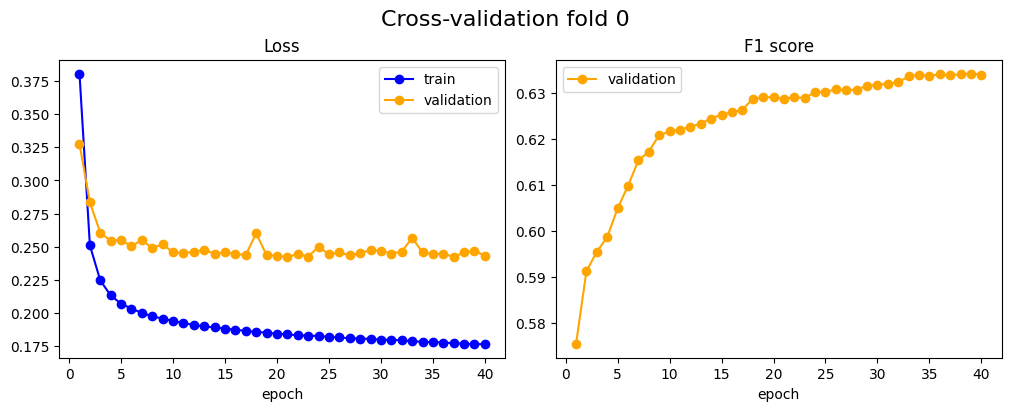

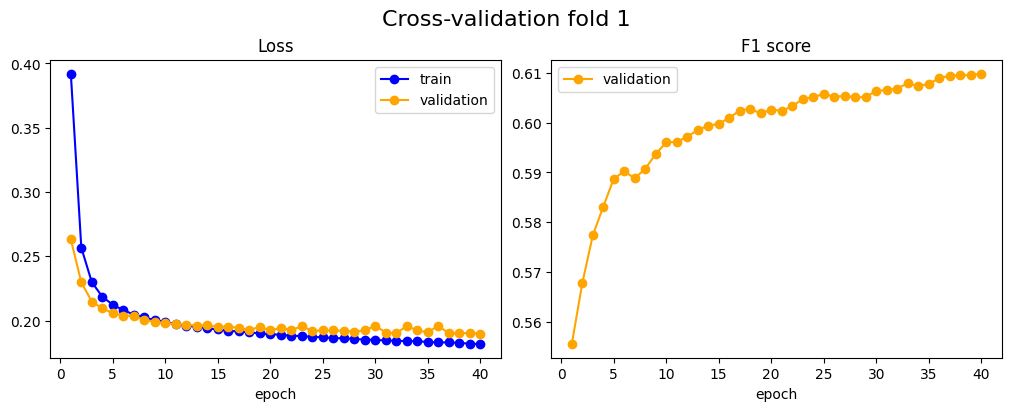

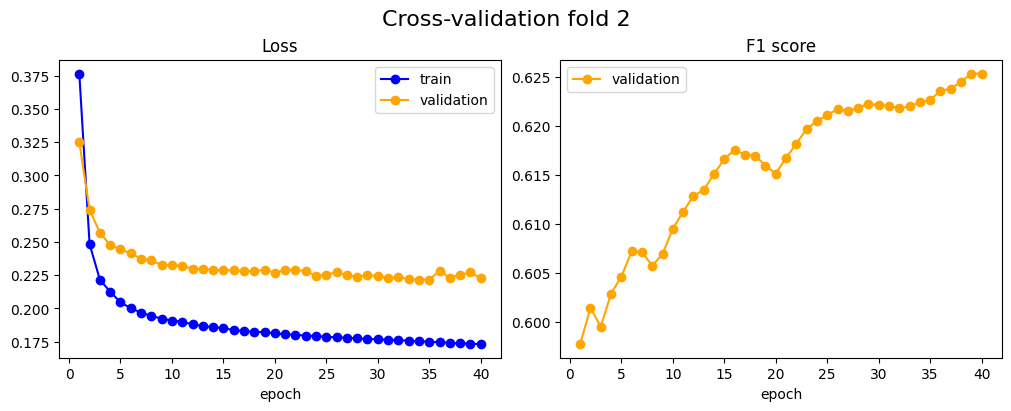

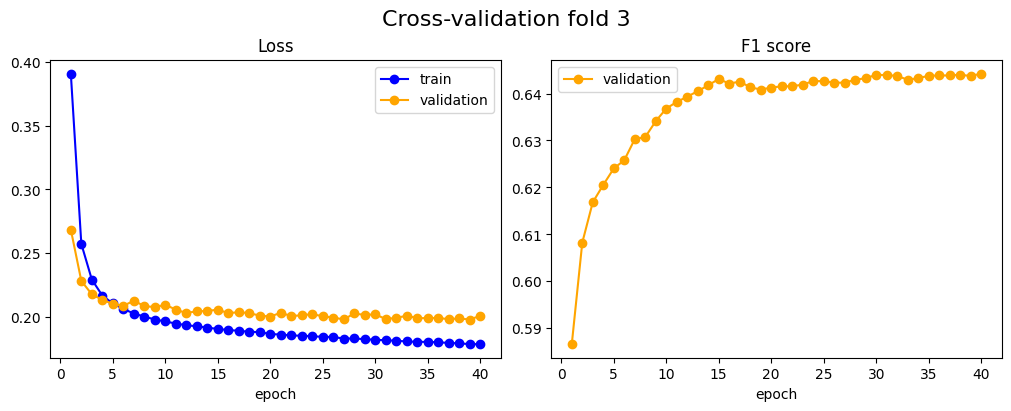

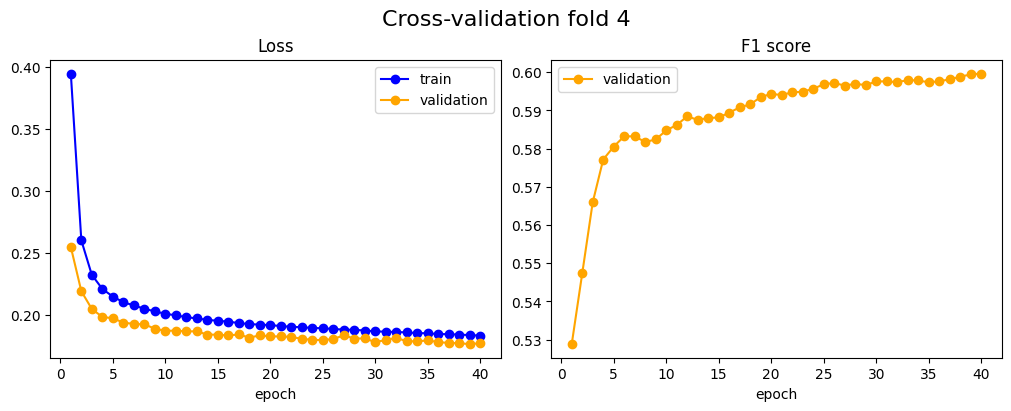

In [41]:
def show_progress(train_loss, valid_loss, valid_metric, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
    epoch = len(train_loss)
    epochs = np.arange(1, epoch+1)
    if title:
        fig.suptitle(title, fontsize=16)
    ax1.set_title('Loss')
    ax1.set_xlabel('epoch')
    ax1.plot(epochs, train_loss, c='blue', label='train', marker='o')
    ax1.plot(epochs, valid_loss, c='orange', label='validation', marker='o')
    ax1.legend()
    ax2.set_title('F1 score')
    ax2.set_xlabel('epoch')
    ax2.plot(epochs, valid_metric, c='orange', label='validation', marker='o')
    ax2.legend()
    plt.show()

for fold in range(k_folds):
    show_progress(train_losses[fold, :], valid_losses[fold, :], valid_metrics[fold, :], f'Cross-validation fold {fold}')

## Evaluation on Training Data

In [39]:
np.argmax(valid_metrics[:,-1])

3

In [31]:
#model_idx = np.argmax(valid_metrics[:,-1])
model_idx = 3
model = ClassificationModel(512, hidden_state, 1)
model = load_model(model, f'tmp/classification-h{hidden_state}-f{model_idx}.pt')

In [32]:
model.to(device=device)

ClassificationModel(
  (ffn): FFN(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [33]:
def predict(inputs, threshold=0.5, batch_size=BATCH_SIZE):
    n_obs = inputs.shape[0]
    pred_labels = np.full((n_obs), np.nan, dtype=np.float32)

    with torch.no_grad():
        for i in range(n_obs // batch_size + 1):
            batch_start, batch_end = i*batch_size, min((i+1)*batch_size, n_obs)
            pred = model(torch.from_numpy(inputs[batch_start:batch_end,:]).to(device=device, dtype=torch.float32))
            probs = nn.Sigmoid()(pred)
            pred_labels[batch_start:batch_end] = probs.cpu()[:,0] > 0.5
            
    return pred_labels

def predict_time_series(model, df):
    pred_X, pred_true, pred_currencies = preprocess_price_data(df)

    currencies = np.unique(pred_currencies)

    fig, axs = plt.subplots(2*len(currencies), 1, figsize=(10, 7*len(currencies)))

    for i, currency in enumerate(currencies):
        currency_df = df.loc[df['currency'] == currency,:]
        pred_labels = predict(pred_X[pred_currencies == currency,:])
        
        ax1 = axs[i*2]
        ax1.plot(currency_df['datetime'], currency_df['open_x'])
        ax1.fill_between(currency_df['datetime'], 0, 1, where=pred_true[pred_currencies == currency], color='red', alpha=0.2, transform=ax1.get_xaxis_transform())
        ax1.set_xlim(currency_df['datetime'].min(), currency_df['datetime'].max())
        ax1.set_title(f'{currency} (true labels)')

        ax2 = axs[i*2+1]
        ax2.plot(currency_df['datetime'], currency_df['open_x'])
        ax2.fill_between(currency_df['datetime'], 0, 1, where=pred_labels, color='red', alpha=0.2, transform=ax2.get_xaxis_transform())
        ax2.set_xlim(currency_df['datetime'].min(), currency_df['datetime'].max())
        ax2.set_title(f'{currency} (predicted labels)')

    plt.show()

In [34]:
train_df['currency'].unique()

array(['ACH', 'ADA', 'ADAUP', 'ADEL', 'AE', 'AERGO', 'AGI', 'AGS', 'AION',
       'AKRO', 'ALGO', 'ALV', 'ALY', 'AMP', 'ANKR', 'ANT', 'ANW', 'APIX',
       'APM', 'AR', 'ARK', 'ARPA', 'AST', 'ATOM', 'ATP', 'AUC', 'AVAX',
       'BAL', 'BAND', 'BCD', 'BCDN', 'BCH', 'BCN', 'BCX', 'BEAR', 'BEL',
       'BHD', 'BHP', 'BIX', 'BKRW', 'BLOC', 'BLZ', 'BNB', 'BNBUP', 'BNT',
       'BNTY', 'BOT', 'BOX', 'BSV', 'BTC', 'BTCDOWN', 'BTCUP', 'BTG',
       'BTMX', 'BTO', 'BTS', 'BTSE', 'BTT', 'BU', 'BULL', 'BZRX', 'CAI',
       'CDT', 'CELO', 'CELR', 'CGLD', 'CHAT', 'CHR', 'CHZ', 'CIC', 'CKB',
       'CLO', 'CMT', 'CND', 'CNN', 'CNTM', 'COCOS', 'COFI', 'COMP',
       'CORN', 'COTI', 'CREAM', 'CRO', 'CRV', 'CTSI', 'CTXC', 'CVC',
       'CVP', 'CVT', 'DAI', 'DASH', 'DATA', 'DBC', 'DCR', 'DDD', 'DENT',
       'DEP', 'DF', 'DGB', 'DGD', 'DHT', 'DIA', 'DILI', 'DKA', 'DMD',
       'DMG', 'DNA', 'DOCK', 'DOGE', 'DOS', 'DOT', 'DOTUP', 'DPY', 'DREP',
       'DRGN', 'DTA', 'DTH', 'DTX', 'DUSK', 'DX', 'EDO', 'EG

  0%|          | 0/2 [00:00<?, ?it/s]

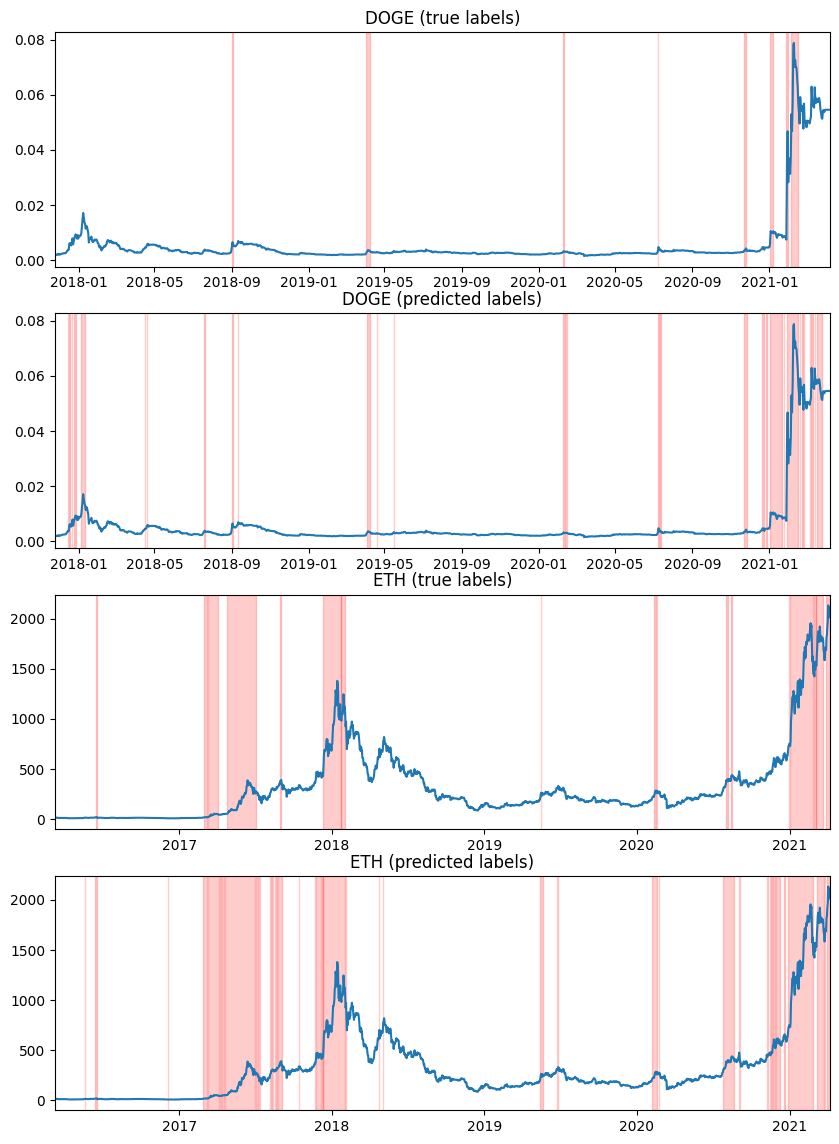

In [35]:
predict_time_series(model, train_df.loc[np.logical_or(train_df['currency'] == 'DOGE', train_df['currency'] == 'ETH')])

## Evaluation on Test Data

In [36]:
test_df['currency'].unique()

array(['ABT', 'ACT', 'ARDR', 'BAT', 'BEAM', 'BTM', 'ETC', 'FET', 'HSC',
       'ICX', 'INT', 'ITC', 'JFI', 'KCASH', 'KNC', 'LTC', 'MDS', 'MTA',
       'NAS', 'NMR', 'OKB', 'ONE', 'PPT', 'REM', 'RIF', 'RNT', 'STEEM',
       'TCT', 'UBTC', 'XLM', 'XPO', 'XRA', 'XTZUP', 'XUC'], dtype=object)

  0%|          | 0/2 [00:00<?, ?it/s]

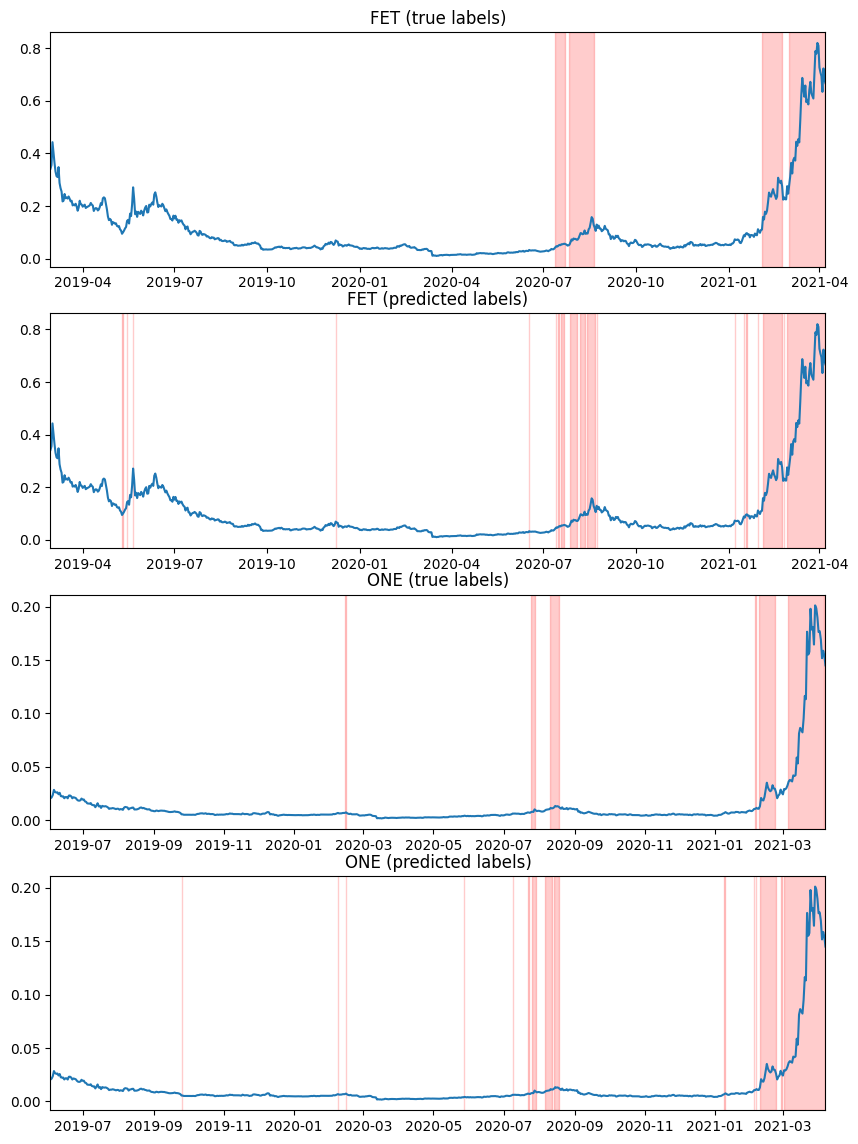

In [37]:
predict_time_series(model, test_df.loc[np.logical_or(test_df['currency'] == 'FET', test_df['currency'] == 'ONE')])

In [ ]:
# TODO F1 score on test data